In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

import yfinance as yf

plt.style.use('fivethirtyeight')

In [2]:
HPG = pd.read_excel('Stock Price - HPG - train.xlsx')
HSG = pd.read_excel('Stock Price - HSG - train.xlsx')
NKG = pd.read_excel('Stock Price - NKG - train.xlsx')

In [3]:
prices_df = pd.concat([HPG['<Close>'], HSG['<Close>'], NKG['<Close>']], axis= 1)
prices_df.columns = ['HPG', 'HSG', 'NKG']
prices_df

,HPG,HSG,NKG
0,23.5371,21.5455,12.0284
1,23.5650,21.6364,12.0284
2,23.8154,21.5455,11.9532
3,23.8154,21.9091,12.0284
4,23.7875,21.9091,11.9532
...,...,...,...
494,17.1000,11.0000,11.5500
495,18.2500,11.7500,12.3500
496,18.2000,11.9000,12.3500
497,18.0000,11.5500,12.2500


Text(0, 0.5, 'price in $')

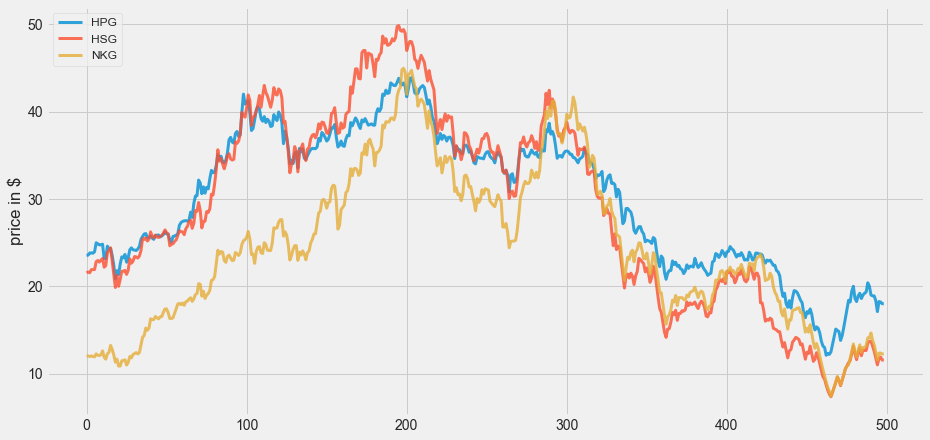

In [4]:
plt.figure(figsize=(14, 7))
for c in prices_df.columns:
    plt.plot(prices_df.index, prices_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

## Returns
Compute the returns as follows:
$$r_t = \frac{p_t}{p_{t-1}}$$

## Log Returns
Compute the log return as follows:
$$ \log r_t = \log \frac{p_t}{p_{t-1}} $$

In [5]:
returns_df = prices_df / prices_df.shift(1)
returns_df = np.log(returns_df[1:])
returns_df

,HPG,HSG,NKG
1,0.001185,0.004210,0.000000
2,0.010570,-0.004210,-0.006271
3,0.000000,0.016735,0.006271
4,-0.001172,0.000000,-0.006271
5,0.006996,0.000000,-0.003151
...,...,...,...
494,-0.070551,-0.070204,-0.071011
495,0.065087,0.065958,0.066971
496,-0.002743,0.012685,0.000000
497,-0.011050,-0.029853,-0.008130


## Sharp ratio
The Sharpe ratio is defined as
$$ SR(W) = \frac{R(W) - R_f}{\sigma(W)} $$
$$ W = [ w_1, w_2, w_3, w_4] $$
$$ \sum_{k = 1}^4 w_k = 1 $$

Since we will look for max $SR(W)$ and $ R_f$ is common for all $w's$, then we shall compute
$$ R(W) = W^T log(r) $$
$$ \sigma(W) = \sqrt(W^T \Sigma W) $$
$$ SR(W) ~ \frac{W^T log(r)}{\sqrt(W^T \Sigma W)}$$

Generate (almost) all possible portfolios

In [6]:
n_portfolios = 10000
weight = np.zeros((n_portfolios, 3))

expected_Return = np.zeros(n_portfolios)
expected_Volatility = np.zeros(n_portfolios)
sharpe_Ratio = np.zeros(n_portfolios)

mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

for i in range(n_portfolios):
    # generate random weight vector
    w = np.array(np.random.random(3))
    w /= np.sum(w)
    weight[i] = w

    # Expected log return
    expected_Return[i] = np.sum(mean_returns * w)

    # Expected volatility
    expected_Volatility[i] = np.sqrt(w @ cov_matrix @ w)

    # Sharpe Ratio
    sharpe_Ratio[i] = expected_Return[i] / expected_Volatility[i]

In [7]:
max_index = sharpe_Ratio.argmax()
weight[max_index]

array([1.34272443e-02, 3.67701459e-05, 9.86535986e-01])

In [8]:
min_index = expected_Volatility.argmin()
weight[min_index]

array([0.98005017, 0.00553733, 0.0144125 ])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1752\2414508555.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Expected Log Return')

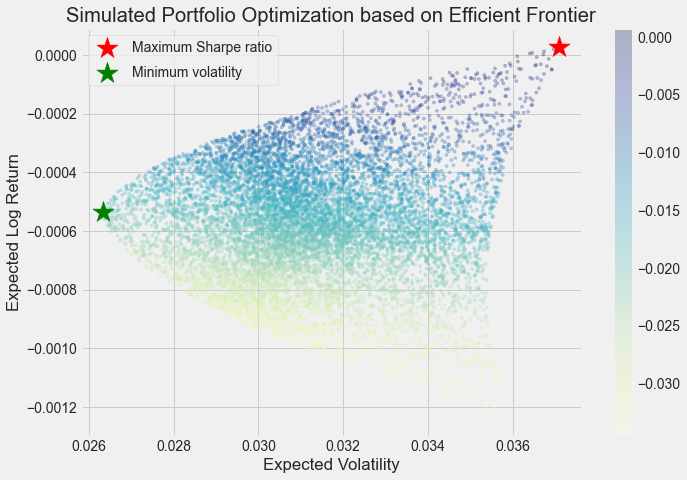

In [9]:
plt.figure(figsize=(10, 7))
plt.scatter(expected_Volatility, expected_Return, c= sharpe_Ratio, cmap='YlGnBu', marker='o', s=10, alpha=0.3)

plt.colorbar()
plt.scatter(expected_Volatility[max_index], expected_Return[max_index], marker='*', color='r', s=500, label='Maximum Sharpe ratio')
plt.scatter(expected_Volatility[min_index], expected_Return[min_index], marker='*', color='g', s=500, label='Minimum volatility')

plt.legend(labelspacing=0.8)
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Return')

## Efficient Markowittz Frontier

\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimize}}
& & W^T \Sigma W \\
& \text{subject to}
& & p^{-T} W \geq r_{min} \\
& && W \geq 0 \\
& &&  1^T W = 1 \\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimize}}
& & W^T \Sigma W \\
& \text{subject to}
& &  0 \leq w_i \leq 1,  (i = 1, \ldots, 4) \\
\end{aligned}
\end{equation*}

In [10]:
def negativeSR(w):
    w = np.array(w)
    R = np.sum(mean_returns * w)
    V = np.sqrt(w @ cov_matrix @ w)
    SR = R / V
    return -SR

w0 = [0.1, 0.1, 0.1]
bounds = ((0, 1), (0, 1), (0, 1))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

w_opt = sco.minimize(negativeSR, w0, method= 'SLSQP', bounds= bounds, constraints= constraints)
w_opt

     fun: -0.000982100302317518
     jac: array([1.49419470e-02, 3.43667701e-02, 1.45519152e-11])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.00000000e+00, 2.77555756e-16, 1.00000000e+00])

In [11]:
returns = np.linspace(expected_Return[min_index], 0.0001, 50)
volatility_opt = []

def minimize_Volatility(w):
    W = np.array(w)
    V = np.sqrt(w @ cov_matrix @ W)
    return V

def get_Return(w):
    W = np.array(w)
    R = np.sum(mean_returns * W)
    return R

for R in returns:
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: get_Return(x) - R})

    opt = sco.minimize(minimize_Volatility, w0, method= 'SLSQP', bounds= bounds, constraints= constraints)

    volatility_opt.append(opt['fun'])

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_1752\3245085489.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Text(0, 0.5, 'Expected Log Return')

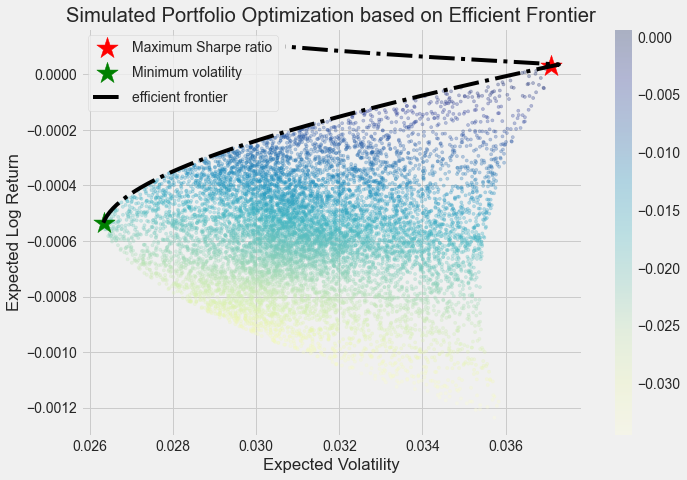

In [12]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(expected_Volatility, expected_Return, c= sharpe_Ratio, cmap='YlGnBu', marker='o', s=10, alpha=0.3)

plt.colorbar()

plt.scatter(expected_Volatility[max_index], expected_Return[max_index], marker='*', color='r', s=500, label='Maximum Sharpe ratio')
plt.scatter(expected_Volatility[min_index], expected_Return[min_index], marker='*', color='g', s=500, label='Minimum volatility')

plt.plot(volatility_opt, returns, linestyle='-.', color='black', label='efficient frontier')
plt.legend(labelspacing=0.8)
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Return')

Text(0, 0.5, 'Expected Log Return')

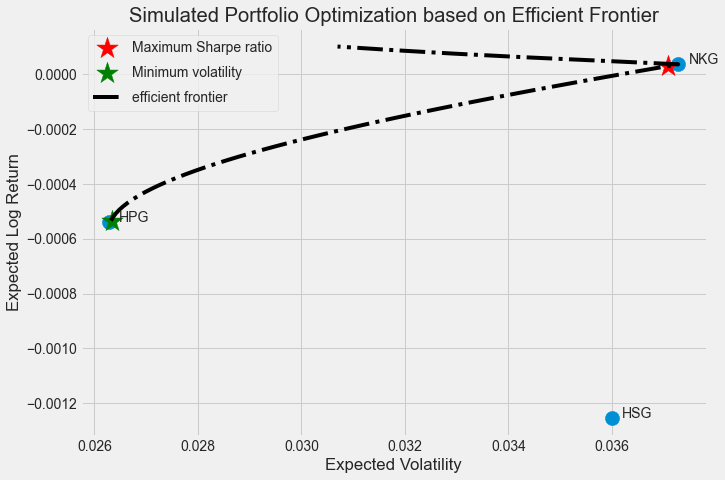

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))
vol = np.std(returns_df)
rt = mean_returns

ax.scatter(vol, rt, marker='o', s=200)
for i, txt in enumerate(returns_df.columns):
    ax.annotate(txt, (vol[i],rt[i]), xytext=(10,0), textcoords='offset points')

plt.scatter(expected_Volatility[max_index], expected_Return[max_index], marker='*', color='r', s=500, label='Maximum Sharpe ratio')
plt.scatter(expected_Volatility[min_index], expected_Return[min_index], marker='*', color='g', s=500, label='Minimum volatility')

plt.plot(volatility_opt, returns, linestyle='-.', color='black', label='efficient frontier')
plt.legend(labelspacing=0.8)
plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Log Return')